## ROC Curve analysis

Understand how to make a ROC curve and use that to compare the predictive performance of two classifiers.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

Consider the following code to a) create a classification problem, b) train two classifiers and c) compute the predictions for some test samples

In [4]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=500, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.1, class_sep=1.0)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=50)

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=5, n_estimators=10)
rf.fit(X_train,y_train)
preds1 = rf.predict_proba(X_test)[:,1]

In [7]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C=5e2)
svm.fit(X_train,y_train)
preds2 = svm.decision_function(X_test)

## Question 1

Make the functions `TPR = true_positive_rate(preds, targets)` and `FPR = false_positive_rate(preds, targets)` to compute the sequence of true (resp. false) positive rates for all possible threshold values.

## Suggestions

Consider the following case:

preds = [0.1, 0.5, 0.2, 0.8, 0.0]

targets = [1, 1, 0, 1, 0]

sort the previous arrays according to the values in `preds`:

sorted_preds = [0.8, 0.5, 0.2, 0.1, 0.0]

sorted_targets = [1, 1, 0, 1, 0]

consider all the possible thresholds: 
- is positive all that is above 0.8 (included)
- is positive all that is above 0.5 (included)
- is positive all that is above 0.2 (included)
- is positive all that is above 0.1 (included)
- is positive all that is above 0.0 (included)

let's  now consider as an example the case: is positive all that is above 0.2 (included)

then we have as predictions:

[1, 1, 1, 0, 0]

that we have to compare to the true targets

[1, 1, 0, 1, 0]

we see that the true positives are

[yes, yes, no, no, no]

and the false positives are

[no, no, yes, no, no]

the number of positives is 3, the number of negatives is 2, so the true positive rate and the false positive rates are

TPR = TP/P = 2/3

FPR = FP/N = 1/2

---

We can now derive the same results only considering the true targets sorted by the predictions:

[1, 1, 0, 1, 0]

we consider implicitly anything until the third position (that would correspond to the threshold 0.2) as predicted positive and the rest as predicted negative 

so we can just count how many times we have a positive target until the third position to obtain the number of true positives

we can then proceed incrementally and count the cumulative number of 1s at each position:

- we have 1 true positive until position 1
- we have 2 true positives until position 2
- we have 2 true positives until position 3
- we have 3 true positives until position 4
- we have 3 true positives until position 5

we can proceed similarly to have an incremental count of the false positives.

At the end we can have an array with the incremental count of true positives and an array with the incremental count of false positives, this is what we need to compute the TPR and FPR and from these the ROC curve.

In [8]:
def true_positive_rate(preds, targets):
    # YOUR CODE HERE
    Threshold = np.sort(preds)
    #print(Threshold)
    preds,targets = [list(x) for x in zip(*sorted(zip(preds, targets), key=lambda pair: pair[0]))]
    TP_final = []
    FN_final = []
    for i in Threshold:
    #preds,targets = [list(x) for x in zip(*sorted(zip(preds, targets), key=lambda pair: pair[0]))]
        predicted_targets = [1 if j>=i else 0 for j in preds]
        TP = [1 if(predicted_targets[j] == targets[j] and predicted_targets[j] ==1) else 0 for j in range(len(predicted_targets)) ]
        FN = [1 if(predicted_targets[j] != targets[j] and predicted_targets[j] ==0) else 0 for j in range(len(predicted_targets)) ]
        TP_count = TP.count(1)
        FN_count = FN.count(1)
        TP_final.append(TP_count/(TP_count + FN_count))
    TP_final = np.flip(TP_final)
    #print(TP_final)
    return TP_final

    
def false_positive_rate(preds, targets):
    #preds,targets = [list(x) for x in zip(*sorted(zip(preds, targets), key=lambda pair: pair[0]))]
    Threshold = np.sort(preds)
    #print(Threshold)
    preds,targets = [list(x) for x in zip(*sorted(zip(preds, targets), key=lambda pair: pair[0]))]
    FP_final = []
    TN_final = []
    for i in Threshold:
    #preds,targets = [list(x) for x in zip(*sorted(zip(preds, targets), key=lambda pair: pair[0]))]
        predicted_targets = [1 if j>=i else 0 for j in preds]
        FP = [1 if(predicted_targets[j] != targets[j] and predicted_targets[j] ==1) else 0 for j in range(len(predicted_targets)) ]
        TN = [1 if(predicted_targets[j] == targets[j] and predicted_targets[j] ==0) else 0 for j in range(len(predicted_targets)) ]
        FP_count = FP.count(1)
        TN_count = TN.count(1)
        FP_final.append(FP_count/(FP_count + TN_count))
    FP_final = np.flip(FP_final)
    return FP_final

In [9]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
test_preds = np.array([0.1, 0.5, 0.2, 0.8, 0.0])
test_targets = np.array([1, 1, 0, 1, 0])

TPR = true_positive_rate(test_preds, test_targets)
FPR = false_positive_rate(test_preds, test_targets)
assert np.sum(np.fabs(TPR - np.array([1/3, 2/3, 2/3, 1, 1]))) < 1e-2, 'The result should be: TPR=[1/3, 2/3, 2/3, 1, 1]'
assert np.sum(np.fabs(FPR - np.array([0. , 0. , 0.5, 0.5, 1. ]))) < 1e-2, 'The result should be: TPR=[0. , 0. , 0.5, 0.5, 1. ]'
### END TESTS

## Question 2

Make the functions `compute_auc(TPR, FPR)` to compute the area under the curve of the ROC. 

Hint: consider the individual rectangles formed by every successive (FPR, TPR) pairs. See the figures below. 

In [17]:
def compute_auc(TPR, FPR):
    # YOUR CODE HERE
    cords = [i for i in zip(FPR, TPR)]
    Areas = []
    for i in range(len(cords)-1):
        cord_1 = cords[i]
        cord_2 = cords[i+1]
        l = 1 - (max(cord_1[0],cord_2[0]))
        b = np.abs(cord_1[1] - cord_2[1])
        print(l*b)
        Areas.append(l*b)
    return sum(Areas)

    #raise NotImplementedError()

In [18]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
test_preds = np.array([0.1, 0.5, 0.2, 0.8, 0.0])
test_targets = np.array([1, 1, 0, 1, 0])

TPR = np.array([1/3, 2/3, 2/3, 1, 1])
FPR = np.array([0. , 0. , 0.5, 0.5, 1. ])

auc = compute_auc(TPR, FPR)
assert np.fabs(auc - 0.83333) < 1e-3, 'AUC should be 0.833 rahter than %.3f'%auc
### END TESTS

0.3333333333333333
0.0
0.16666666666666669
0.0


AssertionError: AUC should be 0.833 rahter than 0.500

## Question 3

Make the function `plot_roc(preds, targets)` to plot the ROC curve. 

You should obtain something like:

<img src='plot.png' width=400>


In [ ]:
def plot_roc(preds, targets):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
test_preds = np.array([0.1, 0.5, 0.2, 0.8, 0.0])
test_targets = np.array([1, 1, 0, 1, 0])
try:
    plot_roc(test_preds, test_targets)
except Exception:
    assert False, 'the function should not raise an exception when asked to plot'
else:
    pass
### END TESTS

## Bonus question 

Make the function `comparative_plot_roc(preds1, preds2, targets)` to plot two ROC curves. 

You should obtain something like:

<img src='plot2.png' width=400>

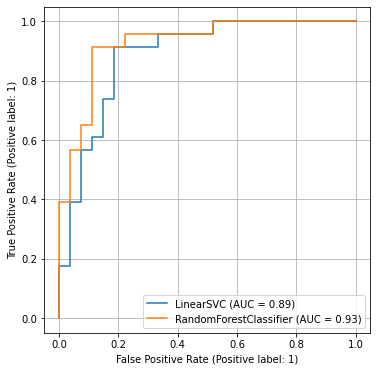

In [14]:
#you can compare visually your implementation against the scikit implementation

from sklearn.metrics import plot_roc_curve
fig, ax = plt.subplots(figsize=(6,6))
plot_roc_curve(svm, X_test, y_test, ax=ax)
plot_roc_curve(rf, X_test, y_test, ax=ax)
ax.set_aspect(1.)
plt.grid()
plt.show()

In [7]:
def comparative_plot_roc(preds1, preds2, targets):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
# This cell is reserved for the unit tests. Do not consider this cell. 
### BEGIN TESTS
test_preds1 = np.array([0.1, 0.5, 0.2, 0.8, 0.0])
test_preds2 = np.array([0.2, 0.3, 0.1, 0.8, 0.6])
test_targets = np.array([1, 1, 0, 1, 0])
try:
    comparative_plot_roc(test_preds1, test_preds2, test_targets)
except Exception:
    assert False, 'the function should not raise an exception when asked to plot'
else:
    pass
### END TESTS

---